# Validating Crime Data Regression Model -- Kristofer Schobert


We have taken the data from the FBI's crime data in New York State in 2013, and Conneticut in 2013.

https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_connecticut_by_city_2013.xls

We will examine our model that is trained on New York crime data, make adjustments, and test it on Conneticut's crime data.

The suggested regression model is the following:

$$property\_crime = \alpha + population + population^2 + murder + robbery + motor\_vehicle\_theft$$


Below is the code that cleans the data and prepares it for this model.

In [270]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from IPython.display import display
from sklearn import linear_model
import statsmodels.formula.api as smf

data_path = 'Crime_2013.csv'
df = pd.read_csv(data_path, header=None)

#note to self: when cleaning data, be mindful of what you dataframe in needed in the end. 
#I spent way too much time cleaning data that I was just going to drop.

df = df.drop([0,1,2,3])
df = df.drop([4, 13], axis=1)
df.columns = df.iloc[0]
df = df.drop([4])
df = df.reset_index()
df = df.drop('index', axis=1)
df.columns.name = None
df = df.drop([348,349,350])

#df = df.rename(str.lower, axis='columns')
df = df.rename(index=str, columns={'City':'city',
                                   'Population':'population',
                                   'Violent\rcrime': "violent_crime",
                                   'Murder and\rnonnegligent\rmanslaughter' : "murder",
                   'Rape\r(legacy\rdefinition)2':'rape',
                   'Robbery':'robbery',
                   'Aggravated\rassault':'aggravated_assault',
                   'Property\rcrime':'property_crime',
                   'Burglary':'burglary',
                   'Larceny-\rtheft':'larceny',
                   'Motor\rvehicle\rtheft': 'motor_vehicle_theft',
                   'Arson3':'arson'})
df = df[['population', 'murder', 'robbery','motor_vehicle_theft', 'property_crime']].copy()

In [271]:
for col in ['population', 'murder', 'robbery', 'motor_vehicle_theft', 'property_crime']:
    df[col] = pd.to_numeric(df[col].str.replace(',',''))


In [272]:

df.murder = np.where(df.murder == 0 , 0, 1)
df.robbery = np.where(df.robbery == 0, 0, 1)
df.motor_vehicle_theft = np.where(df.motor_vehicle_theft <= 8, 0, 1)


NOTE: If motor vehicle theft is less that or equal to 8 it is given the binary value of 0. It is given the value 1 otherwise. 

In [273]:
df['population_squared'] = df['population']**2
list(df.columns.values)
df = df[['property_crime', 'murder', 'robbery', 'motor_vehicle_theft', 'population', 'population_squared']]

In [274]:
df.head()

,property_crime,murder,robbery,motor_vehicle_theft,population,population_squared
0,12,0,0,0,1861,3463321
1,24,0,0,0,2577,6640929
2,16,0,0,0,2846,8099716
3,4090,1,1,1,97956,9595377936
4,223,0,1,0,6388,40806544


In [275]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property_crime']
X = df[['population','population_squared','murder','robbery', 'motor_vehicle_theft']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))



Coefficients: 
 [ 3.57347433e-02 -2.23804032e-09  6.45235818e+01 -6.93717408e+01
 -1.71045535e+02]

Intercept: 
 -113.61522428558021

R-squared:
0.996170504189666


In [276]:
predicted = regr.predict(X).ravel()
actual = Y
# Calculate the error, also called the residual.
residual = actual - predicted


#removing outlier
max(predicted)
for index, value in enumerate(predicted):
    if value == max(predicted):
        outlier_index = index
# df_no_outlier = df.drop([216], axis=0)
df_no_outlier = df.drop(index='216')

In [277]:
df_no_outlier.head()

,property_crime,murder,robbery,motor_vehicle_theft,population,population_squared
0,12,0,0,0,1861,3463321
1,24,0,0,0,2577,6640929
2,16,0,0,0,2846,8099716
3,4090,1,1,1,97956,9595377936
4,223,0,1,0,6388,40806544


In [278]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_outlier['property_crime']
X = df_no_outlier[['population','population_squared','murder','robbery', 'motor_vehicle_theft']]
print(regr.fit(X, Y))

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

y_pred = regr.predict(X)

cross_val_score(regr, X, Y, cv=5)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Coefficients: 
 [8.66691054e-03 1.30128357e-07 1.49641341e+02 7.97535068e+01
 2.37473244e+02]

Intercept: 
 0.7070089548450937

R-squared:
0.8483976957182795


array([0.92700003, 0.800672  , 0.78924552, 0.87427979, 0.32629748])

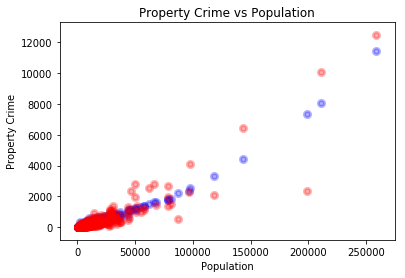

In [279]:
#predicted property crime vs population
plt.scatter(df_no_outlier.population, y_pred, color='blue', alpha = .3, linewidth=3)
plt.scatter(df_no_outlier.population, df_no_outlier.property_crime, color='red', alpha = .3, linewidth=3)
plt.title('Property Crime vs Population')
plt.xlabel('Population')
plt.ylabel('Property Crime')
plt.show()







In [280]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'property_crime ~ population+population_squared+murder+robbery+motor_vehicle_theft'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_no_outlier).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     381.7
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          2.71e-137
Time:                        17:12:23   Log-Likelihood:                -2573.3
No. Observations:                 347   AIC:                             5159.
Df Residuals:                     341   BIC:                             5182.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7070     36.104      0.020      0.984     -70.307      71.721
population              0.0087      0.003      3.352      0.001       0.004       0.014
population_squared   1.301e-07   1.15e-08     11.325      0.000    1.08e-07    1.53e-07
murder                149.6413     77.318      1.935      0.054      -2.438     301.721
robbery                79.7535     51.055      1.562      0.119     -20.670     180.177
motor_vehicle_theft   237.4732     80.138      2.963      0.003      79.846     395.101
==============================================================================
Omnibus:                      391.363   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76250.147
Skew:                          -4.409   Prob(JB):                         0.00
Kurtosis:                      75.084   Cond. No.                     2.05e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Recap

Our linear regression for New York 2013 Crime Data predicts property crime to a reasonable degree. We have used binary variables for murder, robbery and motor vehicle theft and continuous variable for population. We allowed for population squared to be a feature of our model. After removing an outlier we see our model does an alright job fitting the data. This can be seen most clearly in the last figure. The blue points are the models predictions. Notice that they form what looks to be a parabola due to the population squared feature. Also some of these points are displaced slightly vertically from a true parabola because of the binary features. 

We have a resonable good R^2 value for our model, and when using crossvalidation we often earn a good score. These data points to not lie on any line well. Thus, we will always have some low scores in this cross validation.

Upon inspecting the information from the statsmodels ols function. We see that our features are all generally helping.  The intercept is the only feature that is likely zero. Also we have a large f-statistic, meaning our model fits the data much better than a model that always predicts the mean property crime when given any input.  

# Fitting to 2013 Conneticut Crime Data

We will now use our model to predict Conneticut's 2013 Crime Data.



In [281]:
data_path = 'Conneticut_Crime.csv'
df_conn = pd.read_csv(data_path, header=None)

#note to self: when cleaning data, be mindful of what you dataframe in needed in the end. 
#I spent way too much time cleaning data that I was just going to drop.

df_conn = df_conn.drop([0,1,2,3])
df_conn = df_conn.drop([4, 13], axis=1)
df_conn.columns = df_conn.iloc[0]
df_conn = df_conn.drop([4])
df_conn = df_conn.reset_index()
df_conn = df_conn.drop('index', axis=1)
df_conn.columns.name = None
df_conn = df_conn.drop([92,93])


#df = df.rename(str.lower, axis='columns')
df_conn = df_conn.rename(index=str, columns={'City':'city',
                                   'Population':'population',
                                   'Violent\rcrime': "violent_crime",
                                   'Murder and\rnonnegligent\rmanslaughter' : "murder",
                   'Rape\r(legacy\rdefinition)2':'rape',
                   'Robbery':'robbery',
                   'Aggravated\rassault':'aggravated_assault',
                   'Property\rcrime':'property_crime',
                   'Burglary':'burglary',
                   'Larceny-\rtheft':'larceny',
                   'Motor\rvehicle\rtheft': 'motor_vehicle_theft',
                   'Arson3':'arson'})
df_conn = df_conn[['population', 'murder', 'robbery','motor_vehicle_theft', 'property_crime']].copy()

In [282]:
for col in ['population', 'murder', 'robbery', 'motor_vehicle_theft', 'property_crime']:
    df_conn[col] = pd.to_numeric(df_conn[col].str.replace(',',''))
    
df_conn.murder = np.where(df_conn.murder == 0, 0, 1)
df_conn.robbery = np.where(df_conn.robbery == 0, 0, 1)
df_conn.motor_vehicle_theft = np.where(df_conn.motor_vehicle_theft <= 8, 0, 1)  


df_conn['population_squared'] = df_conn['population']**2
list(df_conn.columns.values)
df_conn = df_conn[['property_crime', 'murder', 'robbery', 'motor_vehicle_theft', 'population', 'population_squared']]

df_conn.head()

,property_crime,murder,robbery,motor_vehicle_theft,population,population_squared
0,393,0,1,1,19128,365880384
1,143,0,1,0,18325,335805625
2,277,0,1,1,20657,426711649
3,180,0,0,0,19338,373958244
4,464,1,1,1,20637,425885769


In [283]:
Y_conn = df_conn['property_crime']
X_conn = df_conn[['population','population_squared','murder','robbery', 'motor_vehicle_theft']]

In [284]:
print('\nR-squared:')
print(regr.score(X_conn, Y_conn))
y_pred_conn = regr.predict(X_conn)


R-squared:
0.8255480397122551


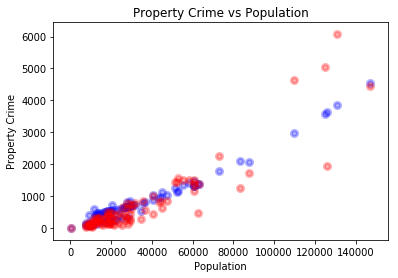

In [285]:
#predicted property crime vs population
plt.scatter(df_conn.population, y_pred_conn, color='blue', alpha = .3, linewidth=3)
plt.scatter(df_conn.population, df_conn.property_crime, color='red', alpha = .3, linewidth=3)
plt.title('Property Crime vs Population')
plt.xlabel('Population')
plt.ylabel('Property Crime')
plt.show()


Our model fitted to the New York 2013 data gives reasonable predictions for the Conneticut 2013 crime data. We have an R^2 value of 82% and upon inspecting the plot of Property Crime vs Population we see that the red Conneticut data points roughly follow the blue predicted Conneticut data points. 

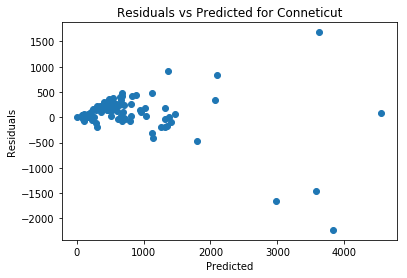

In [290]:
residual_conn = y_pred_conn - df_conn.property_crime
plt.scatter(y_pred_conn,residual_conn)
plt.title('Residuals vs Predicted for Conneticut')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

This plot of residuals vs predicted values shows us that our model becomes more inaccuarte as the amount of property crime increases. We see this from the increasing variance of our plot. Our model is much more accuarate for smaller values of property crime.

In [292]:
np.mean(residual_conn)

76.04150103131191

Our residuals have a positive mean. This indicates that our model, on average, predicts more property damage then their actually is. This may be because Conneticut has lesser crime than New York. 

# Final Thoughts

Our model is fairly successful at predicting the amount of property crime in Conneticut after being trained on New York crime data. The two state seem to show similar behavior in crime. With more population comes more property crime. The same is true for our other binary features. After changing our features some, the features we settled on seem to work well.

This may not be true for other states. We have chosen two states near to eachother. This model may not work as well on states belonging to the United States's west coast. 

However, our model relies heavily on the continuous feature, population. Thus, I expect it would work resonably well on most states crime data. If we were able to create more features from the other crime types, maybe we would have a more accurate model that would predict other states property crime data to an even greater accuracy. 